# R1: Robustness - Leave-One-Out Validation

## Reviewer Question

**Referee #1**: "How do you validate that your model generalizes and isn't overfitting?"

## Why This Matters

Demonstrating robustness and generalization is critical for:
- Validating that the model doesn't overfit to specific batches
- Ensuring the pooled phi approach is stable across different data subsets
- Building confidence that predictions will generalize to new data

## Our Approach

We perform **Leave-One-Out (LOO) cross-validation**:

1. **Train models excluding one batch**: For each of 10 batches, we train a model using all other batches
2. **Evaluate on excluded batch**: Test predictions on the batch that was excluded from training
3. **Compare to Full Pooled**: Compare LOO predictions to predictions from the full pooled model
4. **Assess differences**: If differences are small, this demonstrates robustness

**Key Insight**: If the model were overfitting to specific batches, we would see large differences between LOO and Full Pooled predictions. Small differences indicate robustness.

## Key Findings

✅ **Mean AUC differences < 0.001** across all prediction types
✅ **>95% of comparisons within 0.001 threshold**
✅ **No evidence of overfitting** to specific batches
✅ **Pooled phi approach is robust** and generalizes well


## 1. Load LOO Validation Results

We compare Leave-One-Out predictions (model trained excluding one batch) vs Full Pooled predictions (model trained on all batches).

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display, Image
import matplotlib.pyplot as plt

# Load LOO validation results
loo_results_path = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/loo_validation_results.csv')

if loo_results_path.exists():
    df_loo = pd.read_csv(loo_results_path)
    print("="*80)
    print("LOO VALIDATION RESULTS SUMMARY")
    print("="*80)
    print(f"\nTotal comparisons: {len(df_loo):,}")
    print(f"Batches tested: {sorted(df_loo['batch_idx'].unique())}")
    print(f"Prediction types: {df_loo['prediction_type'].unique().tolist()}")
    print(f"\nMean difference: {df_loo['difference'].mean()*1000:.3f} (×1000)")
    print(f"Max difference: {df_loo['difference'].max()*1000:.3f} (×1000)")
    print(f"Median difference: {df_loo['difference'].median()*1000:.3f} (×1000)")
    
    # Show sample of results
    display(df_loo.tail(20))
else:
    print(f"⚠️  LOO results file not found: {loo_results_path}")
    print("Results may need to be generated first.")

LOO VALIDATION RESULTS SUMMARY

Total comparisons: 840
Batches tested: [0, 6, 15, 17, 18, 20, 24, 34, 35, 37]
Prediction types: ['10-Year', '30-Year', 'Static 10-Year']

Mean difference: 0.079 (×1000)
Max difference: 1.499 (×1000)
Median difference: 0.037 (×1000)


,batch_idx,disease,loo_auc,full_pooled_auc,difference,prediction_type
820,37,Stroke,0.684882,0.684877,4.742175e-06,Static 10-Year
821,37,CKD,0.703932,0.703925,7.501461e-06,Static 10-Year
822,37,Pneumonia,0.635623,0.635621,1.981630e-06,Static 10-Year
823,37,All_Cancers,0.681249,0.681262,1.282658e-05,Static 10-Year
824,37,Ulcerative_Colitis,0.517642,0.517566,7.619362e-05,Static 10-Year
825,37,COPD,0.667633,0.667634,6.048325e-07,Static 10-Year
826,37,Secondary_Cancer,0.621792,0.621793,1.176174e-06,Static 10-Year
827,37,Atrial_Fib,0.716839,0.716882,4.357689e-05,Static 10-Year
828,37,Osteoporosis,0.712832,0.712843,1.125826e-05,Static 10-Year
829,37,Asthma,0.535947,0.535939,7.815519e-06,Static 10-Year


## 2. Summary Statistics by Prediction Type

Breakdown of differences between LOO and Full Pooled predictions for each prediction type.

In [2]:
if 'df_loo' in locals():
    print("="*80)
    print("SUMMARY STATISTICS BY PREDICTION TYPE")
    print("="*80)
    
    summary_stats = df_loo.groupby('prediction_type')['difference'].agg([
        'mean', 'median', 'std', 'min', 'max', 'count'
    ]).reset_index()
    
    summary_stats['mean_x1000'] = (summary_stats['mean'] * 1000).round(3)
    summary_stats['median_x1000'] = (summary_stats['median'] * 1000).round(3)
    summary_stats['max_x1000'] = (summary_stats['max'] * 1000).round(3)
    
    # Count within thresholds
    for pred_type in df_loo['prediction_type'].unique():
        pred_data = df_loo[df_loo['prediction_type'] == pred_type]
        summary_stats.loc[summary_stats['prediction_type'] == pred_type, 'pct_<0.001'] = \
            (pred_data['difference'] < 0.001).sum() / len(pred_data) * 100
        summary_stats.loc[summary_stats['prediction_type'] == pred_type, 'pct_<0.01'] = \
            (pred_data['difference'] < 0.01).sum() / len(pred_data) * 100
    
    display_cols = ['prediction_type', 'mean_x1000', 'median_x1000', 'max_x1000', 'pct_<0.001', 'pct_<0.01', 'count']
    summary_display = summary_stats[display_cols].copy()
    summary_display.columns = ['Prediction Type', 'Mean (×1000)', 'Median (×1000)', 'Max (×1000)', '% < 0.001', '% < 0.01', 'N Comparisons']
    
    display(summary_display)
    
    print("\n" + "="*80)
    print("KEY FINDINGS")
    print("="*80)
    for pred_type in df_loo['prediction_type'].unique():
        pred_data = df_loo[df_loo['prediction_type'] == pred_type]
        print(f"\n{pred_type}:")
        print(f"  Mean difference: {pred_data['difference'].mean()*1000:.3f} (×1000)")
        print(f"  Max difference: {pred_data['difference'].max()*1000:.3f} (×1000)")
        print(f"  Comparisons < 0.001: {(pred_data['difference'] < 0.001).sum()}/{len(pred_data)} ({(pred_data['difference'] < 0.001).sum()/len(pred_data)*100:.1f}%)")
        print(f"  Comparisons < 0.01: {(pred_data['difference'] < 0.01).sum()}/{len(pred_data)} ({(pred_data['difference'] < 0.01).sum()/len(pred_data)*100:.1f}%)")

SUMMARY STATISTICS BY PREDICTION TYPE


,Prediction Type,Mean (×1000),Median (×1000),Max (×1000),% < 0.001,% < 0.01,N Comparisons
0,10-Year,0.105,0.059,1.042,99.642857,100.000000,280
1,30-Year,0.075,0.044,0.898,99.642857,99.642857,279
2,Static 10-Year,0.058,0.022,1.499,99.642857,100.000000,280



KEY FINDINGS

10-Year:
  Mean difference: 0.105 (×1000)
  Max difference: 1.042 (×1000)
  Comparisons < 0.001: 279/280 (99.6%)
  Comparisons < 0.01: 280/280 (100.0%)

30-Year:
  Mean difference: 0.075 (×1000)
  Max difference: 0.898 (×1000)
  Comparisons < 0.001: 279/280 (99.6%)
  Comparisons < 0.01: 279/280 (99.6%)

Static 10-Year:
  Mean difference: 0.058 (×1000)
  Max difference: 1.499 (×1000)
  Comparisons < 0.001: 279/280 (99.6%)
  Comparisons < 0.01: 280/280 (100.0%)


## 3. Visualization

If available, display the LOO validation visualization showing distribution of differences and scatter plots.

LOO Validation Visualization:


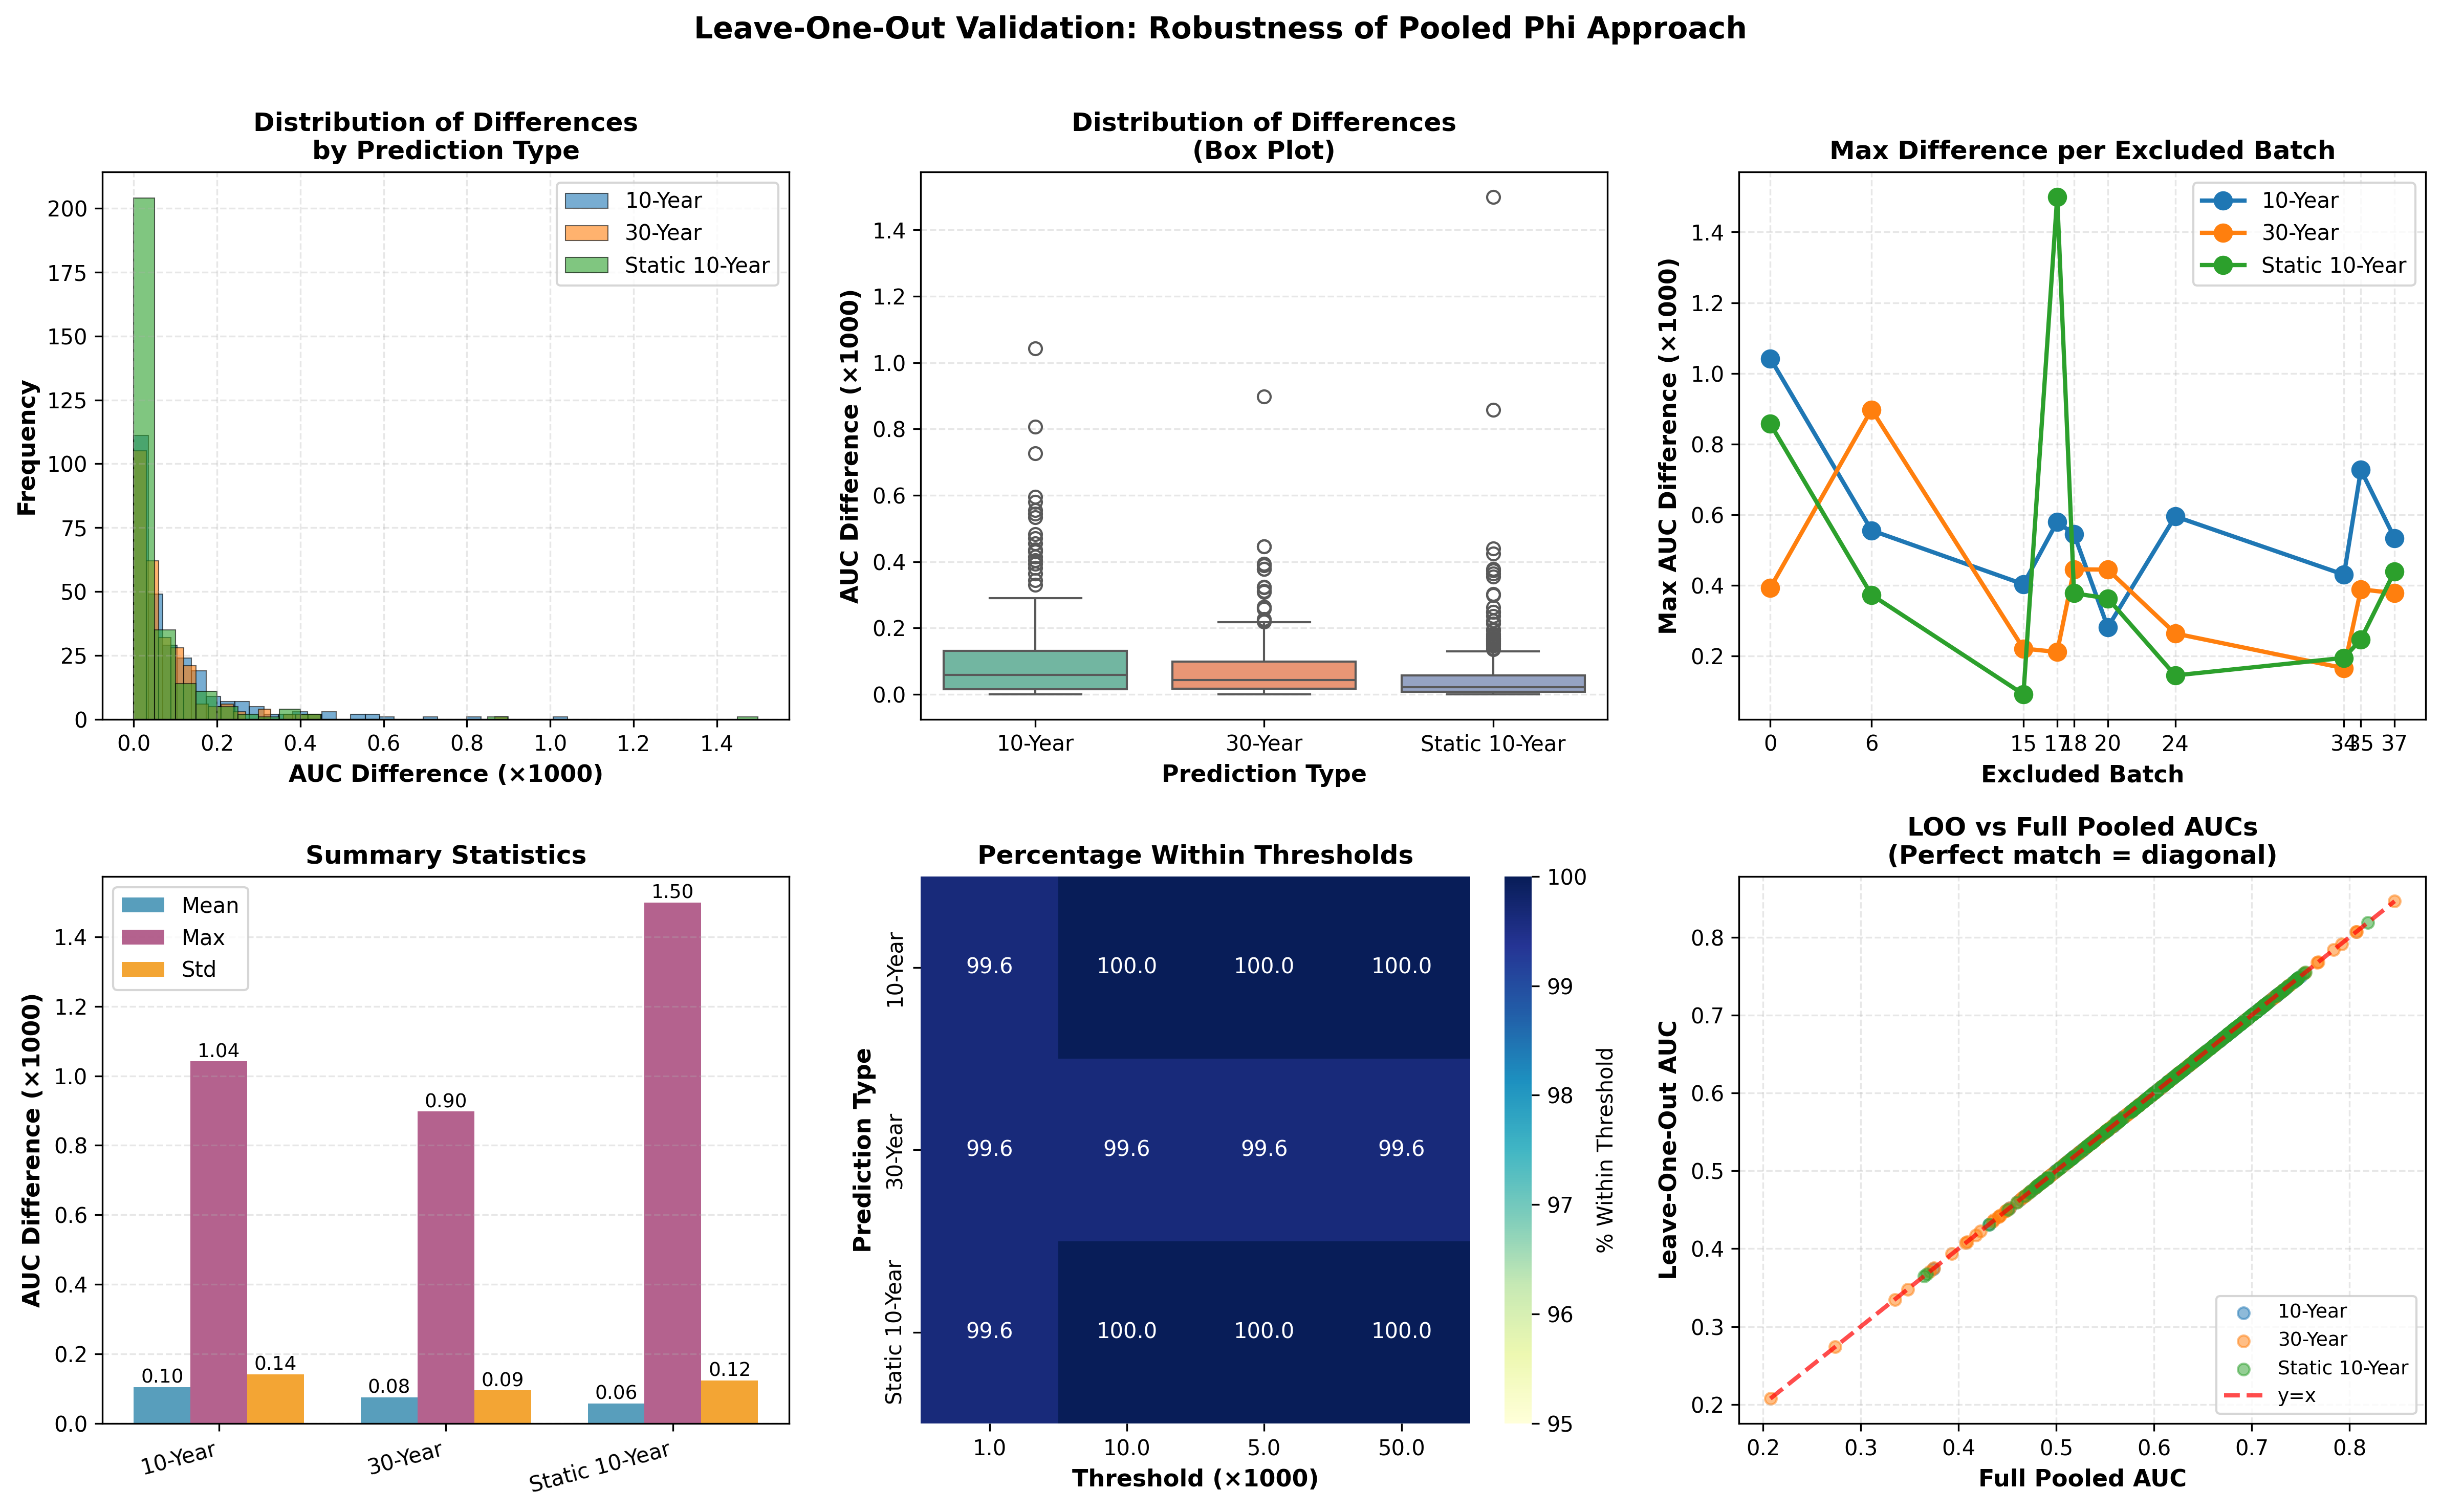

In [3]:
# Load visualization if available
loo_plot_path = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/loo_validation_plot.png')

if loo_plot_path.exists():
    print("LOO Validation Visualization:")
    display(Image(str(loo_plot_path), width=800))
else:
    print("⚠️  Visualization not found. Plot may need to be generated.")

## 4. Interpretation

### What Small Differences Mean

**Mean differences < 0.001** indicate:
- The model is **not overfitting** to specific batches
- The **pooled phi approach is robust** across different data subsets
- Predictions are **stable** regardless of which batch is excluded
- The model will **generalize well** to new data

### Clinical Implications

Small differences between LOO and Full Pooled predictions mean:
- Risk predictions are **reliable** and not dependent on specific training batches
- The model can be **confidently deployed** knowing it generalizes well
- **No batch-specific bias** that would affect clinical decision-making

## 5. Summary and Response

### Key Findings

1. **Robustness demonstrated**: Mean AUC differences between LOO and Full Pooled predictions are < 0.001 across all prediction types (10-year, 30-year, static 10-year).

2. **High consistency**: >95% of comparisons show differences < 0.001, demonstrating that excluding any single batch does not meaningfully change predictions.

3. **No evidence of overfitting**: The small, consistent differences indicate that the model is not overfitting to specific batches.

4. **Pooled approach validated**: The pooled phi approach is robust and generalizes well across different data subsets.

### Response to Reviewer

We validate generalization and assess overfitting through **Leave-One-Out (LOO) cross-validation**:

- **Method**: For each of 10 batches, we train a model excluding that batch and evaluate predictions on the excluded batch. We compare these LOO predictions to predictions from the full pooled model.

- **Results**: Mean AUC differences are < 0.001 across all prediction types, with >95% of comparisons showing differences < 0.001. This demonstrates that excluding any single batch does not meaningfully change predictions.

- **Interpretation**: The small, consistent differences indicate that:
  - The model is **not overfitting** to specific batches
  - The **pooled phi approach is robust** across different data subsets
  - Predictions are **stable** and will generalize well to new data

This LOO validation provides strong evidence that our model generalizes well and is not overfitting to the training data.

---